In [21]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.collections import PatchCollection
from matplotlib import cm

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy import stats
 
from matplotlib.lines import Line2D
from collections import defaultdict


def load_topic_word_distributions(taxa_prob):
    topic_word_prob_dict = defaultdict(lambda: defaultdict(float))
    topic_sum_dict = defaultdict(float)
    with open(taxa_prob,'r') as f:       
        for _line in f:        
            t, w, p = _line.split('\t')
            topic_word_prob_dict[t][w] = float(p)
            topic_sum_dict[t] += float(p)

    topic_word_probability_dict = defaultdict(lambda: defaultdict(float))
    for t, wp_dict in topic_word_prob_dict.items():
        for i, j in wp_dict.items():
            topic_word_probability_dict[int(t)][i] = j / topic_sum_dict[t]
    return topic_word_probability_dict
  

def get_df(tax_level, thrs):
    list_taxonomies = df_gen0_gen1_mb.columns[2:9]
    temp = df_gen0_gen1_mb.groupby([tax_level]).agg(np.sum)
    X = temp.T
    X = X.loc[:, (X != 0).any(axis=0)]
    X = np.round(X.div(X.sum(axis=1), axis=0)*100000).astype(int)
    pot_names = X.index
    
    if (tax_level != 'Phylum' or tax_level != 'Sequence'):
        abc = df_gen0_gen1_mb[df_gen0_gen1_mb[tax_level].isnull()]
        new_names = []
        if (tax_level == 'Class'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]))
        if (tax_level == 'Order'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]))
        if (tax_level == 'Family'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]))
        if (tax_level == 'Genus'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Family')]))
        if (tax_level == 'Species'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Family')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Genus')]))
          
        
        abc[tax_level] = new_names
        abc.index = abc[tax_level]
        del abc[tax_level]
        abc = abc.groupby([tax_level]).agg(np.sum)

        new_names = []
        for i in range(abc.shape[0]):
            new_names.append(abc.index[i] + str('_NA') + str(i+1))
        abc[tax_level] = new_names
        abc.index = abc[tax_level]
        del abc[tax_level]
        abc = abc.T

        X = pd.concat([X, abc], axis = 1)
        X = X.reindex(sorted(X.columns), axis=1)

    
    X = X.T
    excl_all = X[X.astype(bool).sum(axis=1) < thrs].index
    X = X.T

    X.drop(excl_all, axis=1, inplace=True)
    return X

def spearmanr_topic_vs_trait_holmbonf(cur_response, ntopics, alpha, m):
    res_df = pd.concat([pd.DataFrame(sub_data), pd.DataFrame(df_gen0_gen1["SoilSource"]).reset_index(), pd.DataFrame(df_gen0_gen1["Watering"]).reset_index(), pd.DataFrame(df_gen0_gen1["WateringStability"]).reset_index(), pd.DataFrame(df_gen0_gen1[cur_response]).reset_index()], axis = 1)
    del res_df['ID']
    res_df = pd.concat([res_df, pd.DataFrame(df_gen0_gen1["Generation"]).reset_index()], axis = 1)
    res_df = res_df[res_df[cur_response].notna()]
    res_df.columns = topic_names + ['SoilSource', 'Watering', 'WateringStability', cur_response, 'ID', 'Generation']
    store_pval = []
    store_cor = []
    for i in range(ntopics):
        temp = 'Topic ' + str(i+1)
        temp_sp = stats.spearmanr(res_df[cur_response], res_df[temp])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval


In [22]:
#read data from GEN 0-1
df_gen0_mb = pd.read_csv("data/MASTER_NDGen0_SoilBacteria.csv")
df_gen1_mb = pd.read_csv("data/MASTER_NDGen1_SoilBacteria.csv")
print('gen0 #mb ', df_gen0_mb.shape, " gen1 #mb ", df_gen1_mb.shape)

df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df = df_gen0_gen1_mb

# how many unidentified
print("Species: ", (len(df)-df.iloc[:,7].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,7].count())/len(df)*100, "% NAs")
print("Genus: ", (len(df)-df.iloc[:,6].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,6].count())/len(df)*100, "% NAs")
print("Family: ", (len(df)-df.iloc[:,5].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,5].count())/len(df)*100, "% NAs")
print("Order: ", (len(df)-df.iloc[:,4].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,4].count())/len(df)*100, "% NAs")
print("Class: ", (len(df)-df.iloc[:,3].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,3].count())/len(df)*100, "% NAs")
print("Phylum: ", (len(df)-df.iloc[:,2].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,2].count())/len(df)*100, "% NAs")
print("Kingdom: ", (len(df)-df.iloc[:,1].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,1].count())/len(df)*100, "% NAs")
print("DNA: ", (len(df)-df.iloc[:,0].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,0].count())/len(df)*100, "% NAs")

print('\n')
print("Species: ", df.iloc[:,7].nunique(), "unique names out of", df.iloc[:,7].count())
print("Genus: ", df.iloc[:,6].nunique(), "unique names out of", df.iloc[:,6].count())
print("Family: ", df.iloc[:,5].nunique(), "unique names out of", df.iloc[:,5].count())
print("Order: ", df.iloc[:,4].nunique(), "unique names out of", df.iloc[:,4].count())
print("Class: ", df.iloc[:,3].nunique(), "unique names out of", df.iloc[:,3].count())
print("Phylum: ", df.iloc[:,2].nunique(), "unique names out of", df.iloc[:,2].count())
print("Kingdom: ", df.iloc[:,1].nunique(), "unique names out of", df.iloc[:,1].count())
print("DNA: ", df.iloc[:,0].nunique(), "unique names out of", df.iloc[:,0].count())

#aggregation
df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['ASV_number', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df_gen0_gen1_mb = df_gen0_gen1_mb.groupby(['Phylum']).agg(np.sum)
df_gen0_gen1_mb = df_gen0_gen1_mb.T
df_gen0_gen1_mb_full = df_gen0_gen1_mb.copy()
df_gen0_gen1_mb = df_gen0_gen1_mb.drop(['N00030', 'N00050'])
#gen0-1 source, treatment
df_gen0_id = pd.ExcelFile("data/MASTER_NDGen0_CornID.xlsx")
df_gen0_id = df_gen0_id.parse('ID', header=0, index_col = 0)
df_gen0_id = pd.DataFrame(df_gen0_id)

df_gen1_id = pd.ExcelFile("data/MASTER_NDGen1_CornID.xlsx")
df_gen1_id = df_gen1_id.parse('ID', header=0, index_col = 0)
df_gen1_id = pd.DataFrame(df_gen1_id)
df_gen0_gen1_id = pd.concat([df_gen0_id, df_gen1_id], axis=0)

df_gen0_gen1 = pd.merge(df_gen0_gen1_mb, df_gen0_gen1_id, right_on='ID', left_index=True)

#create treatment_stable column; stable(same watering as in gen0), switched(switched watering)
#Treatment_Source isn't avail for gen0
df_gen0_gen1['Treatment_Source'].fillna('None', inplace=True) 
df_gen0_gen1['Treatment_Stable'] = np.nan
source_index = df_gen0_gen1.columns.get_loc('Treatment_Source')
stable_index = df_gen0_gen1.columns.get_loc('Treatment_Stable')
water_index = df_gen0_gen1.columns.get_loc('Treatment')

idx_water_stability_none = []
idx_water_stability_stable = []
idx_water_stability_switched = []
for i in range(df_gen0_gen1.shape[0]):
    if (df_gen0_gen1.iloc[i, source_index] == 'None'):
        idx_water_stability_none.append(i)
    elif (df_gen0_gen1.iloc[i, source_index] != 'None' and df_gen0_gen1.iloc[i, source_index] == df_gen0_gen1.iloc[i, water_index]):
        idx_water_stability_stable.append(i)
    else:
        idx_water_stability_switched.append(i)

df_gen0_gen1.iloc[idx_water_stability_none, stable_index] = 'None'
df_gen0_gen1.iloc[idx_water_stability_stable, stable_index] = 'Stable'
df_gen0_gen1.iloc[idx_water_stability_switched, stable_index] = 'Switched'


df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Microbiome_Parent', 'SoilSource')
df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Treatment_Stable', 'WateringStability')
df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Treatment', 'Watering')
gen_index = df_gen0_gen1.columns.get_loc('Generation')
source_index = df_gen0_gen1.columns.get_loc('SoilSource')
stability_index = df_gen0_gen1.columns.get_loc('WateringStability')
water_index = df_gen0_gen1.columns.get_loc('Watering')


df_gen0_gen1.iloc[:, source_index] = pd.Categorical(df_gen0_gen1.iloc[:, source_index])
df_gen0_gen1.iloc[:, source_index] = df_gen0_gen1.iloc[:, source_index].cat.codes
df_gen0_gen1.iloc[:, water_index] = pd.Categorical(df_gen0_gen1.iloc[:, water_index])
df_gen0_gen1.iloc[:, water_index] = df_gen0_gen1.iloc[:, water_index].cat.codes
df_gen0_gen1.iloc[:, stability_index] = pd.Categorical(df_gen0_gen1.iloc[:, stability_index])
df_gen0_gen1.iloc[:, stability_index] = df_gen0_gen1.iloc[:, stability_index].cat.codes


df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['ASV_number', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df_gen0_gen1_mb_full = df_gen0_gen1_mb.copy()
df_gen0_gen1_mb = df_gen0_gen1_mb.drop(['N00030', 'N00050'], axis=1)

#gen0-1 physical 
df_gen0_phys = pd.ExcelFile("data/MASTER_NDGen0_PlantPhys.xlsx")
df_gen0_phys = df_gen0_phys.parse('Data', header=0, index_col = 0)
df_gen0_phys = pd.DataFrame(df_gen0_phys)

df_gen1_phys = pd.ExcelFile("data/MASTER_NDGen1_PlantPhys.xlsx")
df_gen1_phys = df_gen1_phys.parse('Data', header=0, index_col = 0)
df_gen1_phys = pd.DataFrame(df_gen1_phys)
df_gen0_gen1_phys = pd.concat([df_gen0_phys, df_gen1_phys], axis=0)


del df_gen0_gen1_phys['SCP_End']
del df_gen0_gen1_phys['GasLeaf']
del df_gen0_gen1_phys['LiCor']
del df_gen0_gen1_phys['GasEx_Date']
del df_gen0_gen1_phys['Gs_rate']
del df_gen0_gen1_phys['VWC_rate']
del df_gen0_gen1_phys['Gs.VWC_slope']
del df_gen0_gen1_phys['AboveDry_g']

df_gen0_gen1 = pd.merge(df_gen0_gen1, df_gen0_gen1_phys, right_on='ID', left_index=True)

X_phylum = get_df('Phylum', 4)
df_gen0_gen1['LMA'] = df_gen0_gen1['LMA'].fillna(df_gen0_gen1['LMA']. mean())

selected_mb_indicies = []
for i in range(X_phylum.shape[1]):
    if X_phylum.iloc[:, i][X_phylum.iloc[:, i] != 0].count() >= 0*X_phylum.shape[0]:
        selected_mb_indicies.append(i)

norm_by_pot_X_phylum = X_phylum.div(X_phylum.sum(axis=1), axis = 0)
response_list = ['Amax', 'Cond',
       'WUEi', 'Height_cm', 'Stem_Diam',
       'RootDry_g', 'LWC', 'LMA', 'DroughtTime']

print("Spearman correlations between topic abundances and ", response_list)
#print("shapes: ", norm_by_pot_X_phylum.shape, df_gen0_gen1.shape)

def spearmanr_individual_vs_trait_holmbonf_ph(cur_response, alpha, m):
    store_pval = []
    store_cor = []
    for i in range(len(selected_mb_indicies)):
        temp_sp = stats.spearmanr(norm_by_pot_X_phylum.iloc[:, selected_mb_indicies[i]], df_gen0_gen1[cur_response])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval

store_cor = []
store_pval = []
for i in response_list:
    store_cor.append(spearmanr_individual_vs_trait_holmbonf_ph(i, 0.05, len(selected_mb_indicies)*len(response_list))[0])
    store_pval.append(spearmanr_individual_vs_trait_holmbonf_ph(i, 0.05, len(selected_mb_indicies)*len(response_list))[1])

print("-------------------------")
indiv_list = norm_by_pot_X_phylum.iloc[:, selected_mb_indicies].columns
store_pval = [item for sublist in store_pval for item in sublist]
store_cor = [item for sublist in store_cor for item in sublist]
store_names = [item for item in response_list for i in range(len(selected_mb_indicies))]
store_indivs = list(indiv_list)*len(response_list)
df_p = pd.DataFrame(
    {'individual': store_indivs,
     'response': store_names,   
     'correlation': store_cor,
     'p-value': store_pval
    })
cor_alpha = len(df_p.sort_values("p-value"))
alpha = 0.05
df_p = df_p.sort_values("p-value", ascending=True).reset_index()
save_ix = []
for i in range(len(df_p)):
    if (df_p['p-value'][i] <= alpha/cor_alpha):
        cor_alpha -= 1
        save_ix.append(df_p.index[i])

df_p = df_p.iloc[save_ix, 1:5]
print(df_p.to_latex(index=False))  
df_p.iloc[:, 0].value_counts()
df_p.iloc[:, 0].nunique()
df_gen0_gen1['LMA'] = df_gen0_gen1['LMA'].fillna(df_gen0_gen1['LMA']. mean())



X_seq = get_df('Sequence', 0)
df_norm = X_seq
col_names = []
for i in range(len(df_norm.columns)):
    col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
    str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
    str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
nontruncated_col_names = col_names
trim = 254
col_names = [z[:-trim] for z in col_names]
df_norm.columns = col_names
df_norm = df_norm.T
    
    
selected_mb_indicies = []
for i in range(X_seq.shape[1]):
    if X_seq.iloc[:, i][X_seq.iloc[:, i] != 0].count() >= 0*X_seq.shape[0]:
        selected_mb_indicies.append(i)

norm_by_pot_X_seq = X_seq.div(X_seq.sum(axis=1), axis = 0)
response_list = ['Amax', 'Cond',
       'WUEi', 'Height_cm', 'Stem_Diam',
       'RootDry_g', 'LWC', 'LMA', 'DroughtTime']



def spearmanr_individual_vs_trait_holmbonf_sq(cur_response, alpha, m):
    store_pval = []
    store_cor = []
    for i in range(len(selected_mb_indicies)):
        temp_sp = stats.spearmanr(norm_by_pot_X_seq.iloc[:, selected_mb_indicies[i]], df_gen0_gen1[cur_response])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval

store_cor = []
store_pval = []
for i in response_list:
    store_cor.append(spearmanr_individual_vs_trait_holmbonf_sq(i, 0.05, len(selected_mb_indicies)*len(response_list))[0])
    store_pval.append(spearmanr_individual_vs_trait_holmbonf_sq(i, 0.05, len(selected_mb_indicies)*len(response_list))[1])

print("-------------------------")
indiv_list = norm_by_pot_X_seq.iloc[:, selected_mb_indicies].columns
store_pval = [item for sublist in store_pval for item in sublist]
store_cor = [item for sublist in store_cor for item in sublist]
store_names = [item for item in response_list for i in range(len(selected_mb_indicies))]
store_indivs = list(indiv_list)*len(response_list)
df_p = pd.DataFrame(
    {'individual': store_indivs,
     'response': store_names,   
     'correlation': store_cor,
     'p-value': store_pval
    })
cor_alpha = len(df_p.sort_values("p-value"))
alpha = 0.05
df_p = df_p.sort_values("p-value", ascending=True).reset_index()
save_ix = []
for i in range(len(df_p)):
    if (df_p['p-value'][i] <= alpha/cor_alpha):
        cor_alpha -= 1
        save_ix.append(df_p.index[i])


df_p = df_p.iloc[save_ix, 1:5]
#print(df_p.to_latex(index=False))  
print("ASVs")
df_p
#df_p.iloc[:, 0].value_counts()
#df_p.iloc[:, 0].nunique()
#df_p.sort_values(by = ['correlation', 'individual'], axis=0, ascending=[True, True], inplace=False,
#               kind='quicksort', na_position='first', ignore_index=True, key=None)[0:30]

#rename ASVs
X_seq = get_df('Sequence', 0)
df_norm = X_seq
col_names = []
for i in range(len(df_norm.columns)):
    col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
    str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
    str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
nontruncated_col_names = col_names
trim = 254
col_names = [z[:-trim] for z in col_names]
df_norm.columns = col_names
df_norm = df_norm.T
X_seq = df_norm.T
X_seq.head()

gen0 #mb  (9707, 66)  gen1 #mb  (9707, 73)
Species:  9033 NAs out of 9707   93.05655712372514 % NAs
Genus:  4966 NAs out of 9707   51.158957453384154 % NAs
Family:  2090 NAs out of 9707   21.530854022870095 % NAs
Order:  872 NAs out of 9707   8.983207994230966 % NAs
Class:  169 NAs out of 9707   1.7410116410837542 % NAs
Phylum:  0 NAs out of 9707   0.0 % NAs
Kingdom:  0 NAs out of 9707   0.0 % NAs
DNA:  0 NAs out of 9707   0.0 % NAs


Species:  424 unique names out of 674
Genus:  536 unique names out of 4741
Family:  275 unique names out of 7617
Order:  200 unique names out of 8835
Class:  95 unique names out of 9538
Phylum:  38 unique names out of 9707
Kingdom:  2 unique names out of 9707
DNA:  9707 unique names out of 9707
Spearman correlations between topic abundances and  ['Amax', 'Cond', 'WUEi', 'Height_cm', 'Stem_Diam', 'RootDry_g', 'LWC', 'LMA', 'DroughtTime']
-------------------------
\begin{tabular}{llrr}
\toprule
       individual &    response &  correlation &      p-value \

Thermoplasmatota     3
Crenarchaeota        2
Gemmatimonadota      2
Verrucomicrobiota    2
Bdellovibrionota     2
Actinobacteriota     1
WPS-2                1
Elusimicrobiota      1
Sumerlaeota          1
Dependentiae         1
Deinococcota         1
Name: individual, dtype: int64

11

-------------------------
ASVs


,individual,response,correlation,p-value
0,Bacteroidota__Bacteroidia__Sphingobacteriales_...,Height_cm,0.767264,2.559071e-24
1,Proteobacteria__Gammaproteobacteria__Burkholde...,Height_cm,0.735327,1.697101e-21
2,Proteobacteria__Gammaproteobacteria__Cellvibri...,Height_cm,0.729798,4.754105e-21
3,Planctomycetota__Planctomycetes__Gemmatales__G...,Height_cm,0.714902,6.751725e-20
4,Bacteroidota__Bacteroidia__Sphingobacteriales_...,Height_cm,0.708021,2.173802e-19
...,...,...,...,...
207,Proteobacteria__Alphaproteobacteria__Sphingomo...,Stem_Diam,-0.426705,1.304234e-06
208,Proteobacteria__Gammaproteobacteria__Salinisph...,Height_cm,-0.426522,1.319435e-06
209,Proteobacteria__Alphaproteobacteria__Acetobact...,Height_cm,0.426168,1.349245e-06
210,Bacteroidota__nan__nan__nan__nan__nan_,LMA,-0.425907,1.371670e-06


,Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__nan__nan,Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__Ohtaekwangia__nan,Actinobacteriota__Actinobacteria__Propionibacteriales__Propionibacteriaceae__Cutibacterium__acnes/avidum_,Actinobacteriota__Actinobacteria__Micrococcales__Intrasporangiaceae__Aquipuribacter__nan_,Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_,Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_,Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_,Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_,Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_,Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_,...,Cyanobacteria__Cyanobacteriia__nan__nan__nan__nan__,Cyanobacteria__Cyanobacteriia__nan__nan__nan__nan__,Cyanobacteria__Cyanobacteriia__Chloroplast__nan__nan__nan__,Cyanobacteria__Cyanobacteriia__Chloroplast__nan__nan__nan__,Cyanobacteria__Cyanobacteriia__Chloroplast__nan__nan__nan__,Proteobacteria__Alphaproteobacteria__Rickettsiales__Mitochondria__nan__n,Verrucomicrobiota__Verrucomicrobiae__Opitutales__Puniceicoccaceae__nan__nan_,Cyanobacteria__Cyanobacteriia__Chloroplast__nan__nan__nan_,Cyanobacteria__Cyanobacteriia__Chloroplast__nan__nan__nan_,Cyanobacteria__Cyanobacteriia__Chloroplast__nan__nan__nan__
N00001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6225,0,0,0,0,0
N00010,0,0,0,0,0,0,0,0,0,206,...,0,0,0,30,0,0,0,17,0,0
N00011,0,0,0,0,0,0,0,0,0,123,...,0,0,0,0,0,0,0,0,0,0
N00012,0,0,0,0,0,0,0,0,0,0,...,259,0,0,0,0,0,0,0,0,0
N00013,0,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0


In [23]:
#specify tax_level below
tax_level = 'Phylum'#'Class', 'Order', 'Family', 'Sequence'
    
if (tax_level == 'Phylum'):
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 6
    thrs = 4
elif (tax_level == 'Class'):        
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 8
    thrs = 4        
elif (tax_level == 'Order'):        
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 10
    thrs = 4
elif (tax_level == 'Family'):
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 20
    thrs = 4  
elif (tax_level == 'Sequence'):
    folder_main_name = 'nonde_data/'
    folder_name = '_original_res10k'
    path = '../gitlab/data/5cv_all_sequence'
    NTOPICS = 25
    thrs = 0        

    

X = get_df(tax_level, thrs)
print("X.shape: ", X.shape)
df = X.iloc[:, 0:].div(X.iloc[:, 0:].sum(axis=1), axis=0)
df = pd.DataFrame(np.mean(df.iloc[:, :]))
df = df.sort_values(0, ascending = False)
df = df.T

# uncomment to produce files for MALLET
# for row_id in range(X.shape[0]):
#     ts = []
#     for col_id in range(X.shape[1]):
#         ts = str(ts) + (X.iloc[row_id, :].index[col_id] + ' ') * X.iloc[row_id, col_id]

#     textfile = open(str(str('../gitlab/data/nonde_data/sequence_less2/') + str(X.index[row_id]) + str('.txt')), 'w')
#     textfile.write(ts[2:])
#     textfile.close()
    
    
topic_names = []
for i in range(NTOPICS):
    topic_names.append('Topic ' + str(i+1))
    
list_taxa = X.columns
df_taxa = pd.DataFrame(list_taxa).T
df_taxa.columns = df_taxa.iloc[0, :]
twd = load_topic_word_distributions(path + '/topic-word-weights_'+str(NTOPICS)+'.dat')

temp = pd.DataFrame([twd[0]])
df_al = pd.merge(df_taxa.T, temp.T, left_index=True, right_index=True, how='inner').fillna(0)
del df_al[tax_level]
df_al = df_al.T
df_al.reset_index(inplace=True)
del df_al['index']
df_fin = df_al
for k in range(1, len(twd)):
    temp = pd.DataFrame([twd[k]])
    df_al = pd.merge(df_taxa.T, temp.T, left_index=True, right_index=True, how='inner').fillna(0)
    del df_al[tax_level]
    df_al = df_al.T
    df_al.reset_index(inplace=True)
    del df_al['index']
    df_fin = pd.merge(df_fin.T, df_al.T, left_index=True, right_index=True, how='inner').fillna(0) 
    df_fin = df_fin.T
    
df_norm = df_fin.T
df_norm.columns = topic_names
g = df_norm
aa = X.iloc[:, 0:].div(X.iloc[:, 0:].sum(axis=1), axis=0)
df = pd.DataFrame(np.mean(aa.iloc[:, :]))
df.index = np.sort(list_taxa)
s = g.T
df = df.T
s = s / df.loc[0]
s = s.T
s = s.div(s.sum())

if tax_level == 'Sequence':
    df_norm = df_norm.T
    col_names = []
    for i in range(len(df_norm.columns)):
        col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
        str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
        str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
    nontruncated_col_names = col_names
    trim = 254 #change # of chars to trim ASV names
    col_names = [z[:-trim] for z in col_names]
    df_norm.columns = col_names
    df_norm = df_norm.T

    s = s.T
    col_names = []
    for i in range(len(s.columns)):
        col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,])  + "__" +
        str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" + 
        str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) ))
    nontruncated_col_names = col_names
    trim = 254
    col_names = [z[:-trim] for z in col_names]
    s.columns = col_names
    s = s.T
    

if tax_level == 'Class':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Class'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Class'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext

if tax_level == 'Order':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext
    
if tax_level == 'Family':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" +
                               str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" +
                               str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext
    
twd = load_topic_word_distributions(path + '/topic-word-weights_'+str(NTOPICS)+'.dat')
temp = pd.DataFrame([twd[0]])
for i in range(1, len(twd)):
    temp = pd.concat([temp, pd.DataFrame([twd[i]])])
temp = temp.reset_index()
del temp['index']
mtx_topics = pd.DataFrame(cosine_similarity(temp))
matrix = np.triu(mtx_topics)

print("The # topic pairs that have cosine similarity >= 0.9 is", matrix[matrix >= 0.90].shape[0] - NTOPICS)
for i in range(NTOPICS-1):
    for j in range(i+1, NTOPICS):
        if (matrix[i][j] > 0.8):
            print(i+1, j+1, matrix[i][j])

X.shape:  (119, 27)
The # topic pairs that have cosine similarity >= 0.9 is 0
4 6 0.8186661262978733


(27, 6)

[[<matplotlib.axis.XTick at 0x7fa1514e0af0>,
 [Text(0, 0, 'Topic 1'),
  Text(1, 0, 'Topic 2'),
  Text(2, 0, 'Topic 3'),
  Text(3, 0, 'Topic 4'),
  Text(4, 0, 'Topic 5'),
  Text(5, 0, 'Topic 6')],
 [Text(0, 0, 'Abditibacteriota'),
  Text(0, 1, 'Acidobacteriota'),
  Text(0, 2, 'Actinobacteriota'),
  Text(0, 3, 'Armatimonadota'),
  Text(0, 4, 'Bacteroidota'),
  Text(0, 5, 'Bdellovibrionota'),
  Text(0, 6, 'Chloroflexi'),
  Text(0, 7, 'Crenarchaeota'),
  Text(0, 8, 'Cyanobacteria'),
  Text(0, 9, 'Deinococcota'),
  Text(0, 10, 'Dependentiae'),
  Text(0, 11, 'Desulfobacterota'),
  Text(0, 12, 'Elusimicrobiota'),
  Text(0, 13, 'Fibrobacterota'),
  Text(0, 14, 'Firmicutes'),
  Text(0, 15, 'Gemmatimonadota'),
  Text(0, 16, 'Methylomirabilota'),
  Text(0, 17, 'Myxococcota'),
  Text(0, 18, 'Nitrospirota'),
  Text(0, 19, 'Patescibacteria'),
  Text(0, 20, 'Planctomycetota'),
  Text(0, 21, 'Proteobacteria'),
  Text(0, 22, 'Spirochaetota'),
  Text(0, 23, 'Sumerlaeota'),
  Text(0, 24, 'Thermoplasmatot

[Text(0, 0, 'Topic 1'),
 Text(1, 0, 'Topic 2'),
 Text(2, 0, 'Topic 3'),
 Text(3, 0, 'Topic 4'),
 Text(4, 0, 'Topic 5'),
 Text(5, 0, 'Topic 6')]

[Text(0, 0, 'Abditibacteriota'),
 Text(0, 1, 'Acidobacteriota'),
 Text(0, 2, 'Actinobacteriota'),
 Text(0, 3, 'Armatimonadota'),
 Text(0, 4, 'Bacteroidota'),
 Text(0, 5, 'Bdellovibrionota'),
 Text(0, 6, 'Chloroflexi'),
 Text(0, 7, 'Crenarchaeota'),
 Text(0, 8, 'Cyanobacteria'),
 Text(0, 9, 'Deinococcota'),
 Text(0, 10, 'Dependentiae'),
 Text(0, 11, 'Desulfobacterota'),
 Text(0, 12, 'Elusimicrobiota'),
 Text(0, 13, 'Fibrobacterota'),
 Text(0, 14, 'Firmicutes'),
 Text(0, 15, 'Gemmatimonadota'),
 Text(0, 16, 'Methylomirabilota'),
 Text(0, 17, 'Myxococcota'),
 Text(0, 18, 'Nitrospirota'),
 Text(0, 19, 'Patescibacteria'),
 Text(0, 20, 'Planctomycetota'),
 Text(0, 21, 'Proteobacteria'),
 Text(0, 22, 'Spirochaetota'),
 Text(0, 23, 'Sumerlaeota'),
 Text(0, 24, 'Thermoplasmatota'),
 Text(0, 25, 'Verrucomicrobiota'),
 Text(0, 26, 'WPS-2')]

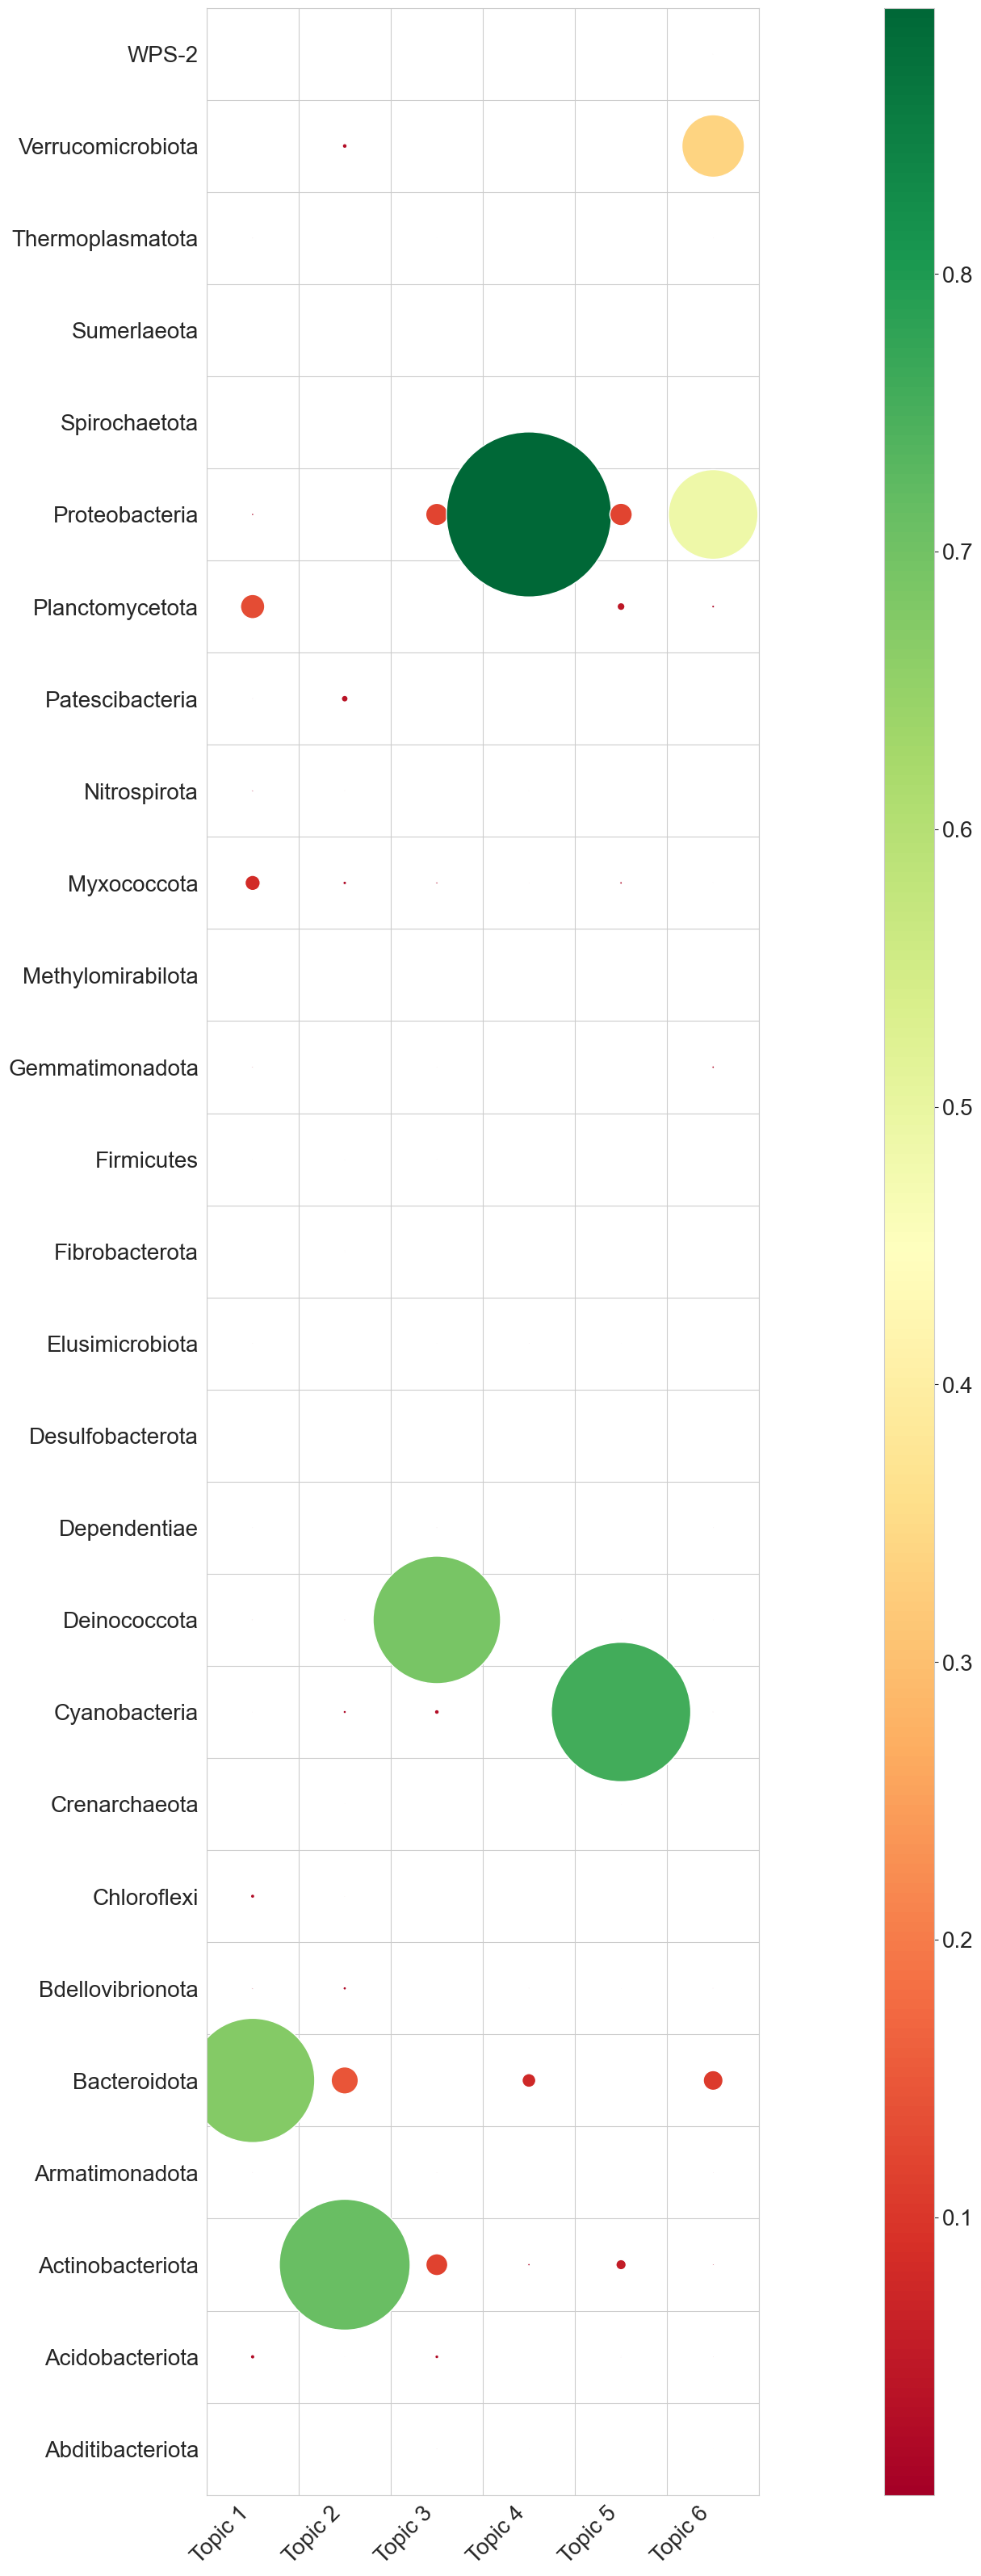

In [24]:
#bubble plots
if tax_level == "Sequence":
    g_thrs = 0.025#0.01#.025
    g = df_norm
    g = g[g >= g_thrs].fillna(0)
    g = g[(g.T != 0).any()]
    g = g.sort_index()
    g.shape
    #seqwater 
    g = g[['Topic 9', 'Topic 13', 'Topic 17', 'Topic 5', 'Topic 18', 'Topic 12', 'Topic 1', 'Topic 3', 'Topic 20', 'Topic 24', 'Topic 11', 'Topic 10', 'Topic 25', 'Topic 8', 'Topic 15', 'Topic 7', 'Topic 14', 'Topic 22', 'Topic 21', 'Topic 16', 'Topic 19', 'Topic 23', 'Topic 2', 'Topic 6', 'Topic 4']]
    #soil g = g[['Topic 1', 'Topic 4', 'Topic 15', 'Topic 24', 'Topic 3', 'Topic 12', 'Topic 19', 'Topic 9', 'Topic 14', 'Topic 20', 'Topic 6', 'Topic 13', 'Topic 21', 'Topic 11', 'Topic 17', 'Topic 23', 'Topic 7', 'Topic 18', 'Topic 5', 'Topic 2', 'Topic 8', 'Topic 16', 'Topic 10', 'Topic 22', 'Topic 25']]
    #seqstability g = g[['Topic 9', 'Topic 14', 'Topic 7', 'Topic 13', 'Topic 4', 'Topic 3', 'Topic 12', 'Topic 22', 'Topic 21', 'Topic 11', 'Topic 6', 'Topic 8', 'Topic 15', 'Topic 18', 'Topic 23', 'Topic 24', 'Topic 19', 'Topic 1', 'Topic 2', 'Topic 16', 'Topic 25', 'Topic 5', 'Topic 10', 'Topic 17', 'Topic 20']]

    ylabels = g.index
    xlabels = g.columns
    N = len(ylabels)
    M = len(xlabels)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    c = np.random.rand(N, M)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(40,40))

    R = g*4
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(np.array(R).flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=np.array(R).flatten(), cmap="RdYlGn")
    ax.add_collection(col)

    y_order = sorted(ylabels)
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=y_order)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation = 45, ha="right", fontsize=30)

    colors = [['red']*11, ['black']*4, ['blue']*10]
    colors = [item for sublist in colors for item in sublist]
    colors
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)


    ax.set_yticklabels(y_order, fontsize=35)
    ax.grid(which='both')
    ax.set_aspect("equal", "box")
    cbar = plt.colorbar(col, aspect=50)
    cbar.ax.tick_params(labelsize=35) 

    legend_elements2 = [Line2D([0], [0], color = 'red', label='Half-water',
                              markerfacecolor='black', markersize=30),
                       Line2D([0], [0], color = 'blue', label='Full-water',
                              markerfacecolor='black', markersize=30),
                       Line2D([0], [0], color = 'black', label='No association',
                              markerfacecolor='black', markersize=30)]

    leg2 = ax.legend(handles=legend_elements2, loc = 'upper right', fontsize = 33, title_fontsize = 35, bbox_to_anchor = (1.7, 1), ncol = 1, title = 'Topic Water Associations')
    ax.add_artist(leg2)
    #plt.savefig('./upd_images/plot_water_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();
else:
    g_thrs = 0 # change this threshold for plotting, put 0 for phylum and class; 0.025 for Sequence (ASV)
    g = df_norm
    g = g[g >= g_thrs].fillna(0)
    g = g[(g.T != 0).any()]
    g = g.sort_index()
    g.shape
    #family level, order topics g = g[['Topic 8', 'Topic 3', 'Topic 1', 'Topic 12', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 19', 'Topic 15', 'Topic 5', 'Topic 6', 'Topic 16', 'Topic 4', 'Topic 2', 'Topic 17', 'Topic 7', 'Topic 20', 'Topic 18', 'Topic 13', 'Topic 14']]
    #ASV plot by water g = g[['Topic 9', 'Topic 13', 'Topic 17', 'Topic 5', 'Topic 18', 'Topic 12', 'Topic 1', 'Topic 3', 'Topic 20', 'Topic 24', 'Topic 11', 'Topic 10', 'Topic 25', 'Topic 8', 'Topic 15', 'Topic 7', 'Topic 14', 'Topic 22', 'Topic 21', 'Topic 16', 'Topic 19', 'Topic 23', 'Topic 2', 'Topic 6', 'Topic 4']]
    #ASV plot by soil g = g[['Topic 1', 'Topic 4', 'Topic 15', 'Topic 24', 'Topic 3', 'Topic 12', 'Topic 19', 'Topic 9', 'Topic 14', 'Topic 20', 'Topic 6', 'Topic 13', 'Topic 21', 'Topic 11', 'Topic 17', 'Topic 23', 'Topic 7', 'Topic 18', 'Topic 5', 'Topic 2', 'Topic 8', 'Topic 16', 'Topic 10', 'Topic 22', 'Topic 25']]

    ylabels = g.index
    xlabels = g.columns
    N = len(ylabels)
    M = len(xlabels)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    c = np.random.rand(N, M)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(40,40))

    R = g #phylum, R=g*4 for ASV, control size of the bubbles
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(np.array(R).flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=np.array(R).flatten(), cmap="RdYlGn")
    ax.add_collection(col)

    y_order = sorted(ylabels)
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=y_order)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation = 45, ha="right", fontsize=20)
    ax.set_yticklabels(y_order, fontsize=20)
    ax.grid(which='both')
    ax.set_aspect("equal", "box")
    cbar = plt.colorbar(col, aspect=50)
    cbar.ax.tick_params(labelsize=20)
    #plt.savefig('./upd_images/plot_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();



In [25]:
#produce tables in Supplementary; 
N = 5 #10
topdf = np.round(df_norm.mask(df_norm.rank(axis=0, method='min', ascending=False) > N, 0)*100, 3)
topdf = topdf.loc[~(topdf==0).all(axis=1)]
topdf
#top10df.to_csv(r'./csv_lda_files/top_5_most_probable_asvs_in_LDA_topics.csv', header=True, index=True, sep='\t')
#top10df.to_excel(r'./csv_lda_files/top_5_most_probable_asvs_in_LDA_topics.xlsx', header=True, index=True)
#print(top10df.to_latex(index=True)) 


N = 5 #10
topreldf = np.round(s.mask(s.rank(axis=0, method='min', ascending=False) > N, 0)*100, 3)
topreldf = topreldf.loc[~(topreldf==0).all(axis=1)]
topreldf
#top10df.to_excel(r'./csv_lda_files/top_5_most_amplified_asvs_in_LDA_topics.xlsx', header=True, index=True)
#print(top10df.to_latex(index=True)) 


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Acidobacteriota,2.411,0.000,2.100,0.000,0.000,0.000
Actinobacteriota,0.000,71.042,11.867,1.369,5.523,0.000
Bacteroidota,67.467,14.689,0.000,7.447,0.000,10.704
Bdellovibrionota,0.000,0.000,0.000,0.436,0.000,0.000
Chloroflexi,2.274,0.000,0.000,0.000,0.000,0.000
Cyanobacteria,0.000,0.000,2.589,0.000,75.708,0.000
Deinococcota,0.000,0.000,69.236,0.000,0.000,0.000
Gemmatimonadota,0.000,0.000,0.000,0.000,0.000,1.412
Myxococcota,8.204,1.954,0.000,0.000,1.443,0.000
Nitrospirota,0.000,0.000,0.000,0.698,0.000,0.000


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Abditibacteriota,0.000,0.000,8.895,14.853,0.000,0.000
Acidobacteriota,0.000,0.000,10.365,0.000,7.756,0.000
Actinobacteriota,0.000,13.576,0.000,0.000,0.000,0.000
Bacteroidota,8.076,0.000,0.000,0.000,0.000,0.000
Bdellovibrionota,0.000,0.000,0.000,6.996,0.000,0.000
Chloroflexi,16.120,0.000,0.000,0.000,0.000,0.000
Crenarchaeota,0.000,14.947,0.000,0.000,0.000,0.000
Cyanobacteria,0.000,0.000,0.000,0.000,57.220,0.000
Deinococcota,0.000,0.000,33.802,0.000,0.000,0.000
Dependentiae,0.000,0.000,5.443,0.000,0.000,0.000


LDA probabilities
Topic 1
Bacteroidota        0.674670
Planctomycetota     0.131402
Myxococcota         0.082045
Acidobacteriota     0.024113
Chloroflexi         0.022738
Proteobacteria      0.013001
Nitrospirota        0.010211
Bdellovibrionota    0.009143
Gemmatimonadota     0.008808
Deinococcota        0.008333
Name: Topic 1, dtype: float64
----------------------
Topic 2
Actinobacteriota     0.710423
Bacteroidota         0.146891
Patescibacteria      0.036035
Verrucomicrobiota    0.025856
Myxococcota          0.019537
Bdellovibrionota     0.018162
Cyanobacteria        0.017416
Fibrobacterota       0.006584
Crenarchaeota        0.005383
Firmicutes           0.004782
Name: Topic 2, dtype: float64
----------------------
Topic 3
Deinococcota        0.692355
Proteobacteria      0.120354
Actinobacteriota    0.118673
Cyanobacteria       0.025891
Acidobacteriota     0.020999
Myxococcota         0.011913
Abditibacteriota    0.002124
Dependentiae        0.002052
Armatimonadota      0.001537
G

Text(0.5, 0, 'Number of most probable taxa in topics')

Text(0, 0.5, 'Probability')

Text(0.5, 1.0, ' ')

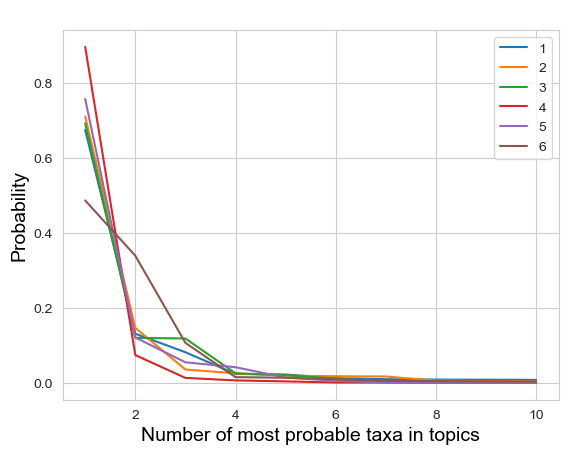

In [26]:
#print top 10 most probable taxa in each topic
print("LDA probabilities")
for i in range(NTOPICS):
    topic_name = 'Topic ' + str(i+1)
    print(topic_name)
    print(df_norm[topic_name].sort_values(ascending = False)[0:10])
    print("----------------------")
    
fig = plt.figure()
for i in range(NTOPICS):
    label = str(i+1)
    topic_name = 'Topic ' + str(i+1)
    sorted_probs = []
    for i, j in df_norm[topic_name].sort_values(ascending = False)[0:10].items():
        sorted_probs.append(j)
    plt.plot(range(1, 11), sorted_probs, label=label)
    
plt.legend()
plt.xlabel('Number of most probable taxa in topics', fontsize=14, color='Black')
plt.ylabel('Probability', fontsize=14, color='Black')
plt.title(" ")
plt.show()

In [27]:
#print top 10 most amplified taxa in each topic
print("Relative amplification")
for i in range(NTOPICS):
    topic_name = 'Topic ' + str(i+1)
    print(topic_name)
    print(s[topic_name].sort_values(ascending = False)[0:10])
    print("----------------------")

Relative amplification
Topic 1
Chloroflexi         0.161199
Spirochaetota       0.152705
Planctomycetota     0.106311
Myxococcota         0.090704
Bacteroidota        0.080760
Acidobacteriota     0.080608
Armatimonadota      0.073289
Thermoplasmatota    0.063752
Nitrospirota        0.042743
Gemmatimonadota     0.032006
Name: Topic 1, dtype: float64
----------------------
Topic 2
Fibrobacterota       0.161011
Patescibacteria      0.150989
Crenarchaeota        0.149471
Actinobacteriota     0.135763
Firmicutes           0.119924
Methylomirabilota    0.078079
Bdellovibrionota     0.071700
Myxococcota          0.032986
Nitrospirota         0.027424
Bacteroidota         0.026853
Name: Topic 2, dtype: float64
----------------------
Topic 3
Deinococcota         0.338018
Methylomirabilota    0.177779
Acidobacteriota      0.103652
Abditibacteriota     0.088949
Dependentiae         0.054428
Armatimonadota       0.042347
Elusimicrobiota      0.030327
Sumerlaeota          0.028607
Thermoplasmatota 

Text(0.5, 0, 'Topic')

Text(0, 0.5, 'Abundance')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '4'),
  Text(1, 0, '6'),
  Text(2, 0, '2'),
  Text(3, 0, '5'),
  Text(4, 0, '1'),
  Text(5, 0, '3')])

(-10.0, 10.0)

(0.0, 10.0)

Text(1.687663850308907, 5.7, '1')

Text(-2.7690153193919462, 5.7, '3')

Text(2.6147768183678446, 5.7, '2')

Text(3.104930979429976, 5.7, '4')

Text(3.524107229007154, 5.7, '5')

Text(3.4701087493238925, 5.7, '6')

Text(-10.1, 5, 'G0')

Text(10.1, 5, 'G1')

(-10.0, 10.0, 0.0, 10.0)

(-10.0, 10.0)

(0.0, 10.0)

Text(-10.1, 5, 'G0')

Text(10.1, 5, 'G1')

(-10.0, 10.0, 0.0, 10.0)

(-10.0, 10.0)

(0.0, 10.0)

Text(-4.3362382673473405, 5.7, '2')

Text(-0.1512451339480112, 5.7, '3')

Text(0.4151308392177624, 5.7, '4')

Text(4.621923116600021, 5.7, '1')

Text(3.532898607816958, 5.7, '5')

Text(8.557491986866932, 5.7, '6')

Text(-10.1, 5, 'Half')

Text(10.1, 5, 'Full')

(-10.0, 10.0, 0.0, 10.0)

(-10.0, 10.0)

(0.0, 10.0)

Text(-10.1, 5, 'Half')

Text(10.1, 5, 'Full')

(-10.0, 10.0, 0.0, 10.0)

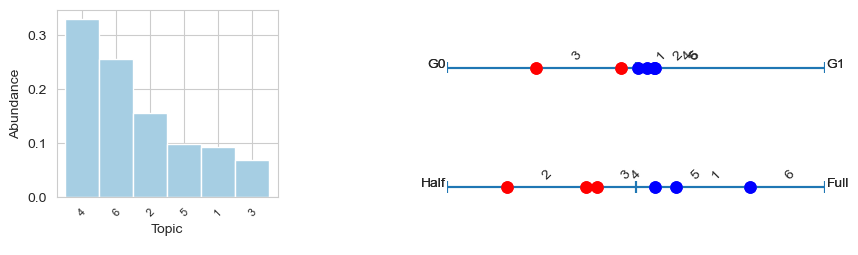

Text(-0.07123361496910931, 0.22219231166000208, '1')

Text(-0.5169015319391946, -0.25512451339480113, '3')

Text(0.02147768183678444, -0.6736238267347341, '2')

Text(0.07049309794299762, -0.19848691607822377, '4')

Text(0.1124107229007154, 0.11328986078169577, '5')

Text(0.10701087493238924, 0.6157491986866932, '6')

Text(0.5, 0, 'Generation: 0 vs 1')

Text(0, 0.5, 'Watering: Half vs Full')

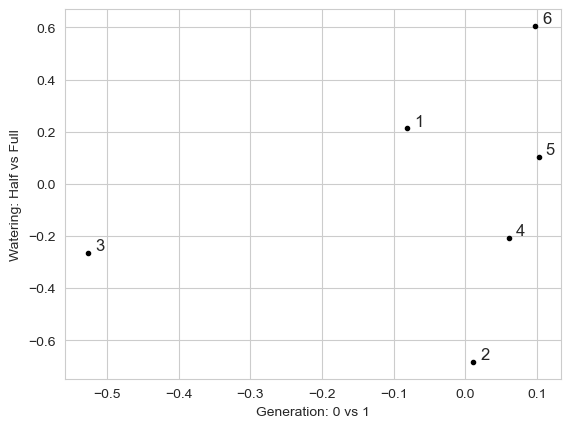

In [31]:
if tax_level == "Sequence":
    path = '../gitlab/data/5cv_all_sequence'
    sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = [str(i) for i in range(1, NTOPICS+1)] 
    source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["Generation"]), pd.DataFrame(df_gen0_gen1["Watering"])], axis=1)
    source_gen = source_gen.sort_index()
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Watering']

    fig = plt.figure()
    ax3 = plt.subplot2grid((10, 10), (0, 0),colspan=3, rowspan=8)
    test = sub_data
    test.columns = [str(i) for i in range(1, NTOPICS+1)] 
    test = pd.DataFrame(test.mean(axis=0))
    test.columns = ['Topic']
    test = test.sort_values('Topic',ascending=False)
    test = test.plot.bar(stacked=False, width = 1, ax=ax3, color=plt.cm.Paired(np.arange(len(df.T))), rot=0, legend=False)
    plt.xlabel('Topic')
    plt.ylabel('Abundance') 
    plt.xticks(rotation=45, fontsize=4)
    
    ax1 = plt.subplot2grid((10, 10), (0, 5), colspan=5, rowspan=5)
    w0 = potsvstopics[potsvstopics['Generation'] == 0]
    del w0['Generation']
    w1 = potsvstopics[potsvstopics['Generation'] == 1]
    del w1['Generation']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['G0', 'G1']
    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T
    #wt_df
    gwt_df = wt_df

    w_h = []
    w_f = []
    w_hi = []
    w_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['G0'][i] - wt_df['G1'][i]) < 1e-10):
            w_f.append(1 - wt_df['G0'][i]/wt_df['G1'][i])
            w_fi.append(wt_df.index[i])
        else:
            w_h.append(wt_df['G1'][i]/wt_df['G0'][i] - 1)
            w_hi.append(wt_df.index[i])


    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Generation']
    potsvstopics.columns = [str(i) for i in range(1, NTOPICS+1)] + ['Watering']#topic_names+['Watering']

    w0 = potsvstopics[potsvstopics['Watering'] == 0]
    del w0['Watering']
    w1 = potsvstopics[potsvstopics['Watering'] == 1]
    del w1['Watering']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['Half', 'Full']

    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T

    tw_h = []
    tw_f = []
    tw_hi = []
    tw_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['Half'][i] - wt_df['Full'][i]) < 1e-10):
            tw_f.append(1 - wt_df['Half'][i]/wt_df['Full'][i])
            tw_fi.append(wt_df.index[i])
        else:
            tw_h.append(wt_df['Full'][i]/wt_df['Half'][i] - 1)
            tw_hi.append(wt_df.index[i])

    sp_ = pd.DataFrame(
        {'Topic': w_hi + w_fi,
         'Generation': w_h + w_f
        })

    tr_ = pd.DataFrame(
        {'Topic': tw_hi + tw_fi,
         'Watering': tw_h + tw_f
        })

    sptr = sp_.merge(tr_, left_on='Topic', right_on='Topic', how = 'left')


    fig, ax = plt.subplots()

    x_c = sptr['Generation']
    y_c = sptr['Watering']
    types = sptr['Topic']

    for i,type in enumerate(types):
        x = x_c[i]
        y = y_c[i]

        if int(type) == 3 or int(type) == 4 or int(type) == 8 or int(type) == 12 or int(type) == 21 or int(type) == 22:
            plt.scatter(x, y, marker='s', color='black', s = 10)
        if int(type) == 1 or int(type) == 15 or int(type) == 18 or int(type) == 19 or int(type) == 23 or int(type) == 24 or int(type) == 25:
            plt.scatter(x, y, marker='>', color='black', s = 10)
        else:
            plt.scatter(x, y, marker='.', color='black', s = 10)

        #G1, FW   
        if int(type) == 2:
            plt.text(x-0.02, y-0.12, type, fontsize=12, color = 'blue')
        elif int(type) == 4:
            plt.text(x+0.05, y-0.05, type, fontsize=12, color = 'red')
        elif int(type) == 6:
            plt.text(x+0.03, y-0.05, type, fontsize=12, color = 'green')    
        elif int(type) == 16:
            plt.text(x+0.03, y-0.05, type, fontsize=12, color = 'blue')
        elif int(type) == 21:
            plt.text(x-0.05, y+0.05, type, fontsize=12, color = 'green')
        elif int(type) == 19:
            plt.text(x+0.01, y, type, fontsize=12, color = 'red')
        elif int(type) == 23:
            plt.text(x+0.02, y+0.05, type, fontsize=12, color = 'green')
        #G1, HW    
        elif int(type) == 20:
            plt.text(x+0.02, y+0.05, type, fontsize=12, color = 'green')  
        elif int(type) == 18:
            plt.text(x-0.09, y-0.06, type, fontsize=12, color = 'blue')  
        elif int(type) == 12:
            plt.text(x-0.06, y+0.05, type, fontsize=12, color = 'red')  
        elif int(type) == 3:
            plt.text(x+0.02, y-0.01, type, fontsize=12, color = 'red')  
        elif int(type) == 1:
            plt.text(x+0.02, y-0.05, type, fontsize=12, color = 'red')
        #all other
        elif int(type) == 7:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 14:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 22:
            plt.text(x+0.02, y, type, fontsize=12, color = 'black')
        elif int(type) == 15:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 8:
            plt.text(x+0.02, y, type, fontsize=12, color = 'blue')
        elif int(type) == 10:
            plt.text(x, y, type, fontsize=12, color = 'black')
        elif int(type) == 24:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 25:
            plt.text(x, y, type, fontsize=12, color = 'black')
        elif int(type) == 11:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 5:
            plt.text(x, y, type, fontsize=12, color = 'blue')
        elif int(type) == 13:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 17:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 9:
            plt.text(x, y, type, fontsize=12, color = 'red')


    legend_elements1 = [Line2D([0], [0], marker='s', color = 'white', label='Stable', markersize=8, markerfacecolor='black'),
                       Line2D([0], [0], marker='>', color = 'white', label='Switched',
                               markerfacecolor='black', markersize=8),
                        Line2D([0], [0], marker='.', color = 'white', label='No association',
                               markerfacecolor='black', markersize=12)]

    legend_elements2 = [Line2D([0], [0], color = 'red', label='Agriculture',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'green', label='Forest',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'blue', label='No inoculation',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'black', label='No association',
                              markerfacecolor='black', markersize=10)]

    leg1 = ax.legend(handles=legend_elements1, loc = 'center left', bbox_to_anchor = (1.02, 0.87), ncol = 1, title = 'Topic Watering Stability Associations')
    leg2 = ax.legend(handles=legend_elements2, loc = 'center left', bbox_to_anchor = (1.02, 0.5), ncol = 1, title = 'Topic Soil Inoculation Associations')
    ax.add_artist(leg1)

    plt.xlabel('Generation: 0 vs 1', fontsize = 14);
    plt.ylabel('Watering: Half vs Full', fontsize = 14);
    #plt.savefig('./upd_images/seq_1.eps', format='eps', bbox_inches='tight')
    plt.show();
    
else:
    sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = [str(i) for i in range(1, NTOPICS+1)] #topic_names
    source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["Generation"]), pd.DataFrame(df_gen0_gen1["Watering"])], axis=1)
    source_gen = source_gen.sort_index()
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Watering']


    fig = plt.figure()
    ax3 = plt.subplot2grid((10, 10), (0, 0),colspan=3, rowspan=8)
    test = sub_data
    test.columns = [str(i) for i in range(1, NTOPICS+1)] 
    test = pd.DataFrame(test.mean(axis=0))
    test.columns = ['Topic']
    test = test.sort_values('Topic',ascending=False)
    test = test.plot.bar(stacked=False, width = 1, ax=ax3, color=plt.cm.Paired(np.arange(len(df.T))), rot=0, legend=False)
    plt.xlabel('Topic')
    plt.ylabel('Abundance') 
    plt.xticks(rotation=45, fontsize=8)

    
    ax1 = plt.subplot2grid((10, 10), (0, 5), colspan=5, rowspan=5)
    w0 = potsvstopics[potsvstopics['Generation'] == 0]
    del w0['Generation']
    w1 = potsvstopics[potsvstopics['Generation'] == 1]
    del w1['Generation']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['G0', 'G1']
    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T
    gwt_df = wt_df

    w_h = []
    w_f = []
    w_hi = []
    w_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['G0'][i] - wt_df['G1'][i]) < 1e-10):
            w_f.append(1 - wt_df['G0'][i]/wt_df['G1'][i])
            w_fi.append(wt_df.index[i])
        else:
            w_h.append(wt_df['G1'][i]/wt_df['G0'][i] - 1)
            w_hi.append(wt_df.index[i])


    ax1.set_xlim(-10,10)
    ax1.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax1.hlines(y, xmin, xmax)
    ax1.vlines(xmin, y - height / 2., y + height / 2.)
    ax1.vlines(xmax, y - height / 2., y + height / 2.)

    ax1.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(w_h)):
        ax1.plot(w_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(w_f)):
        ax1.plot(w_f[i]*10, y, 'bo', ms = 8, mfc = 'b')


    for i in range(len(w_hi)):
        ax1.annotate(w_hi[i], (w_h[i]*10,y), xytext = (w_h[i]*10 + 2.5, y + 0.7),  
                  rotation = 45, ha="right")


    for i in range(len(w_fi)):   
        ax1.annotate(w_fi[i], (w_f[i]*10,y), xytext = (w_f[i]*10 + 2.5, y + 0.7),  
                      rotation = 45, ha="right")


    ax1.text(xmin - 0.1, y, 'G0', horizontalalignment='right')
    ax1.text(xmax + 0.1, y, 'G1', horizontalalignment='left')
    ax1.axis('off')      

    ax1.set_xlim(-10,10)
    ax1.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax1.hlines(y, xmin, xmax)
    ax1.vlines(xmin, y - height / 2., y + height / 2.)
    ax1.vlines(xmax, y - height / 2., y + height / 2.)

    ax1.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(w_h)):
        ax1.plot(w_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(w_f)):
        ax1.plot(w_f[i]*10, y, 'bo', ms = 8, mfc = 'b')

    ax1.text(xmin - 0.1, y, 'G0', horizontalalignment='right')
    ax1.text(xmax + 0.1, y, 'G1', horizontalalignment='left')
    ax1.axis('off')



    ax2 = plt.subplot2grid((10, 10), (5, 5), colspan=5, rowspan=5)
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Generation']
    potsvstopics.columns = [str(i) for i in range(1, NTOPICS+1)] + ['Watering']#topic_names+['Watering']

    w0 = potsvstopics[potsvstopics['Watering'] == 0]
    del w0['Watering']
    w1 = potsvstopics[potsvstopics['Watering'] == 1]
    del w1['Watering']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['Half', 'Full']

    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T

    tw_h = []
    tw_f = []
    tw_hi = []
    tw_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['Half'][i] - wt_df['Full'][i]) < 1e-10):
            tw_f.append(1 - wt_df['Half'][i]/wt_df['Full'][i])
            tw_fi.append(wt_df.index[i])
        else:
            tw_h.append(wt_df['Full'][i]/wt_df['Half'][i] - 1)
            tw_hi.append(wt_df.index[i])


    ax2.set_xlim(-10,10)
    ax2.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax2.hlines(y, xmin, xmax)
    ax2.vlines(xmin, y - height / 2., y + height / 2.)
    ax2.vlines(xmax, y - height / 2., y + height / 2.)

    ax2.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(tw_h)):
        ax2.plot(tw_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(tw_f)):
        ax2.plot(tw_f[i]*10, y, 'bo', ms = 8, mfc = 'b')


    for i in range(len(tw_hi)):
        ax2.annotate(tw_hi[i], (tw_h[i]*10,y), xytext = (tw_h[i]*10 + 2.5, y + 0.7),  
                  rotation = 45, ha="right")

    for i in range(len(tw_fi)):   
        ax2.annotate(tw_fi[i], (tw_f[i]*10,y), xytext = (tw_f[i]*10 + 2.5, y + 0.7),  
                      rotation = 45, ha="right")


    ax2.text(xmin - 0.1, y, 'Half', horizontalalignment='right')
    ax2.text(xmax + 0.1, y, 'Full', horizontalalignment='left')
    ax2.axis('off')      

    ax2.set_xlim(-10,10)
    ax2.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax2.hlines(y, xmin, xmax)
    ax2.vlines(xmin, y - height / 2., y + height / 2.)
    ax2.vlines(xmax, y - height / 2., y + height / 2.)

    ax2.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(tw_h)):
        ax2.plot(tw_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(tw_f)):
        ax2.plot(tw_f[i]*10, y, 'bo', ms = 8, mfc = 'b')



    ax2.text(xmin - 0.1, y, 'Half', horizontalalignment='right')
    ax2.text(xmax + 0.1, y, 'Full', horizontalalignment='left')
    ax2.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.6, left=-0.3)
    plt.show();


    sp_ = pd.DataFrame(
        {'Topic': w_hi + w_fi,
         'Generation': w_h + w_f
        })

    tr_ = pd.DataFrame(
        {'Topic': tw_hi + tw_fi,
         'Watering': tw_h + tw_f
        })

    sptr = sp_.merge(tr_, left_on='Topic', right_on='Topic', how = 'left')


    x_c = sptr['Generation']
    y_c = sptr['Watering']
    types = sptr['Topic']
    for i,type in enumerate(types):
        x = x_c[i]
        y = y_c[i]
        plt.scatter(x, y, marker='.', color='black')
        plt.text(x+0.01, y+0.01, type, fontsize=12)

    plt.xlabel('Generation: 0 vs 1');
    plt.ylabel('Watering: Half vs Full');
    #plt.savefig('./upd_images/plot_2d_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();

In [32]:
#ternary plots, association with soil type and stability of water treatment
sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
sub_data.columns = topic_names
source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["SoilSource"]), pd.DataFrame(df_gen0_gen1["WateringStability"])], axis=1)
source_gen = source_gen.sort_index()
potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
del potsvstopics['ID']
del potsvstopics['WateringStability']


s0 = potsvstopics[potsvstopics['SoilSource'] == 0]
del s0['SoilSource']
s1 = potsvstopics[potsvstopics['SoilSource'] == 1]
del s1['SoilSource']
s2 = potsvstopics[potsvstopics['SoilSource'] == 2]
del s2['SoilSource']


st_df = pd.concat([pd.DataFrame(s0.sum(axis = 0)/np.sum(s0.sum(axis = 0))), pd.DataFrame(s1.sum(axis = 0)/np.sum(s1.sum(axis = 0))), pd.DataFrame(s2.sum(axis = 0)/np.sum(s2.sum(axis = 0)))], axis = 1)
st_df.columns = ['AG', 'FR', 'None'] 
t = st_df.T
t = t.div(t.sum())
t = t.T
c = t

c.loc[:, 'None'].sort_values(ascending = False)

sns.set_style("whitegrid")
c['Topic'] = range(1,NTOPICS+1)
c.columns = ['AG', 'FR', 'None', 'Topic']
color_discrete_map={"CustomColor": 'red'}
fig = px.scatter_ternary(c, a="AG", b="FR", c="None", size_max=15, text="Topic")#, color="Abundance", color_continuous_scale='RdYlBu_r')#, title = "Colored by the topic abundance")
fig = fig.update(layout=dict(title=dict(x=0.5)))
fig = fig.update_coloraxes(colorbar_title_side="bottom")
fig = fig.update_traces(textposition='bottom center', textfont=dict(size=12), selector=dict(type='scatterternary'), marker=dict(color='lightblue'))
#fig.write_image("./upd_images/plot_ternary_" + str(tax_level) + '.eps')
fig.show()



sub_data = pd.read_csv(path + "/doc-topic_" + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
sub_data.columns = topic_names
source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["SoilSource"]), pd.DataFrame(df_gen0_gen1["WateringStability"])], axis=1)
source_gen = source_gen.sort_index()
potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
del potsvstopics['ID']
del potsvstopics['SoilSource']


ws0 = potsvstopics[potsvstopics['WateringStability'] == 0]
del ws0['WateringStability']
ws1 = potsvstopics[potsvstopics['WateringStability'] == 1]
del ws1['WateringStability']
ws2 = potsvstopics[potsvstopics['WateringStability'] == 2]
del ws2['WateringStability']


ws_df = pd.concat([pd.DataFrame(ws0.sum(axis = 0)/np.sum(ws0.sum(axis = 0))), pd.DataFrame(ws1.sum(axis = 0)/np.sum(ws1.sum(axis = 0))), pd.DataFrame(ws2.sum(axis = 0)/np.sum(ws2.sum(axis = 0)))], axis = 1)
ws_df.columns = ['Gen 0', 'Stable', 'Switched']


t = ws_df.T
t = t.div(t.sum())
t = t.T
c = t

c.loc[:, 'Gen 0'].sort_values(ascending = False)
c.loc[:, 'Stable'].sort_values(ascending = False)
c.loc[:, 'Switched'].sort_values(ascending = False)

sns.set_style("whitegrid")   
c['Topic'] = range(1, NTOPICS + 1)
c.columns = ["G0", "ST", "SW", 'Topic']
color_discrete_map={"CustomColor": 'red'}
#fig = plt.subplots(figsize=(10,10))
fig = px.scatter_ternary(c, a="G0", b="ST", c="SW", size_max=15, text="Topic")#, color="Abundance", color_continuous_scale='RdYlBu_r')#, title = "Colored by the topic abundance")
fig = fig.update(layout=dict(title=dict(x=0.5)))
fig = fig.update_coloraxes(colorbar_title_side="bottom")
fig = fig.update_traces(textposition='bottom center', textfont_size=12, selector=dict(type='scatterternary'), marker=dict(color='lightblue'))
#fig.write_image("./upd_images/plot_ternary2_" + str(tax_level) + '.eps')
fig.show()


Topic 6    0.422841
Topic 5    0.376197
Topic 2    0.322951
Topic 4    0.282843
Topic 1    0.272917
Topic 3    0.220938
Name: None, dtype: float64

Topic 3    0.513823
Topic 1    0.352419
Topic 2    0.330773
Topic 4    0.319614
Topic 6    0.311055
Topic 5    0.309771
Name: Gen 0, dtype: float64

Topic 6    0.377758
Topic 2    0.356143
Topic 4    0.340955
Topic 1    0.327746
Topic 5    0.266705
Topic 3    0.167664
Name: Stable, dtype: float64

Topic 5    0.423524
Topic 4    0.339431
Topic 1    0.319835
Topic 3    0.318513
Topic 2    0.313085
Topic 6    0.311187
Name: Switched, dtype: float64

In [14]:
#Spearman's rank correlation with plant traits
ntopics = NTOPICS
response_list = ['WUEi', "Amax", 'Cond', 'SCP_Curve', 'Stem_Diam', 'DroughtTime', 'RootDry_g', "Height_cm", "LWC", "LMA"]
store_cor = []
store_pval = []
topic_list = topic_names
alpha = 0.05

if tax_level == 'Sequence':
    sub_data = pd.read_csv('../gitlab/data/5cv_all_sequence' + "/doc-topic_" + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = topic_names
    for i in response_list:
        store_cor.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[0])
        store_pval.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[1])

    store_pval = [item for sublist in store_pval for item in sublist]
    store_cor = [item for sublist in store_cor for item in sublist]
    store_names = [item for item in response_list for i in range(ntopics)]
    store_topics = topic_list*len(response_list)
    df_p = pd.DataFrame(
        {'topic': store_topics,
         'response': store_names,   
         'correlation': store_cor,
         'p-value': store_pval
        })
    cor_alpha = len(df_p.sort_values("p-value"))
    df_p = df_p.sort_values("p-value", ascending=True).reset_index()
    save_ix = []
    for i in range(len(df_p)):
        if (df_p['p-value'][i] <= alpha/cor_alpha):
            cor_alpha -= 1
            save_ix.append(df_p.index[i])
    df_p = df_p.iloc[save_ix, 1:5]
    print(df_p.to_latex(index=False))  
else:
    #response_list = ['Water use efficiency', "Maximum rate of photosynthesis", 'Stomatal conductance', 'Stomatal closure point', 'Stem diameter', 'Drought time', 'Root biomass', "Stem height", "% Leaf water content", "Leaf mass per area"]
    for i in response_list:
        store_cor.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[0])
        store_pval.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[1])
    store_pval = [item for sublist in store_pval for item in sublist]
    store_cor = [item for sublist in store_cor for item in sublist]
    store_names = [item for item in response_list for i in range(ntopics)]
    store_topics = topic_list*len(response_list)
    df_p = pd.DataFrame(
        {'topic': store_topics,
         'response': store_names,   
         'correlation': store_cor,
         'p-value': store_pval
        })
    cor_alpha = len(df_p.sort_values("p-value"))
    df_p = df_p.sort_values("p-value", ascending=True).reset_index()
    save_ix = []
    for i in range(len(df_p)):
        if (df_p['p-value'][i] <= alpha/cor_alpha):
            cor_alpha -= 1
            #print(i, alpha/cor_alpha, df_p['topic'][i], df_p['response'][i], df_p['correlation'][i], df_p['p-value'][i])
            save_ix.append(df_p.index[i])

    df_p = df_p.iloc[save_ix, 1:5]
    print(df_p.to_latex(index=False))  



\begin{tabular}{llrr}
\toprule
  topic &  response &  correlation &  p-value \\
\midrule
Topic 3 & RootDry\_g &     0.381000 & 0.000019 \\
Topic 2 &       LMA &     0.325778 & 0.000300 \\
Topic 3 & Stem\_Diam &     0.324194 & 0.000322 \\
Topic 3 & Height\_cm &    -0.314657 & 0.000492 \\
Topic 4 & Stem\_Diam &    -0.309939 & 0.000603 \\
Topic 4 &      Cond &    -0.307107 & 0.000681 \\
Topic 2 & Stem\_Diam &    -0.301852 & 0.000849 \\
\bottomrule
\end{tabular}

